# Exploring reddit data using Spark

This notebook provides startup code for downloading Reddit data from the Azure Blob Storage bucket specifically setup for this project.   
_<b>Make sure you are running this notebook on a cluster which has the credentials setup to access Azure Blob Storage, otherwise this notebook will not be able to read the data!</b>_

_<b>Make sure you are using DataBricks Runtime 11.3 or newer otherwise you will not be able to save any new files in this repository!</b>_

The dataset for this notebook is described in [The Pushshift Reddit Dataset](https://arxiv.org/pdf/2001.08435.pdf) paper.

## Read the data
Let us begin with listing the file in the bucket. There are two folders `comments` and `submissions`, we will read both of them into separate Spark dataframes. The raw data is in [parquet format](https://www.databricks.com/glossary/what-is-parquet#:~:text=What%20is%20Parquet%3F,handle%20complex%20data%20in%20bulk.).

In [0]:
dbutils.fs.ls("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet")

Out[6]: [FileInfo(path='abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments/', name='comments/', size=0, modificationTime=1666557328000),
 FileInfo(path='abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions/', name='submissions/', size=0, modificationTime=1666559745000)]

In [0]:
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

The `count` operation below will take several minutes, it is show here because it provides an oppurtunity to look at the Spark UI will a computation is in progress. Expand the `Spark Jobs` output in the result cell to see how the job is progressing and then drill down into task details.

In [0]:
#comments_row_count = comments.count()
#comment_col_count = len(comments.columns)

In [0]:
#print(f"shape of the comments dataframe is {comments_row_count:,}x{comment_col_count}")

A glimpse of the data and the schema.

In [0]:
comments.show()

+------------------+--------------+----------------------+--------------------+--------------------+--------+----------------+-----------+-------------+------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+--------------------+------------+
|            author|author_cakeday|author_flair_css_class|   author_flair_text|                body|can_gild|controversiality|created_utc|distinguished|edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|retrieved_on|score|stickied|           subreddit|subreddit_id|
+------------------+--------------+----------------------+--------------------+--------------------+--------+----------------+-----------+-------------+------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+--------------------+------------+
|        FieldOfFox|          null|                  null|                null|  Music taste is bad|    true|               

In [0]:
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



## Exploratory Data Analysis

Here is an example of some EDA. But, before we do that let us setup some local directory structure so that that the results can be checked in into the repo.

In [0]:
## create a directory called data/plots and data/csv to save generated data
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

### How many subreddits are there and which are the more popular ones

One of the first questions we can ask is how many subreddits are there and which ones are the top 10 based on the number of submissions.

In [0]:
from pyspark.sql.functions import col, asc,desc
submissions_by_subreddit = submissions.groupBy("subreddit").count().orderBy(col("count"), ascending=False).collect()

In [0]:
submissions_by_subreddit

Out[14]: [Row(subreddit='AskReddit', count=6579206),
 Row(subreddit='FreeKarma4U', count=4523825),
 Row(subreddit='GaySnapchat', count=3304753),
 Row(subreddit='dirtykikpals', count=3247581),
 Row(subreddit='memes', count=2769676),
 Row(subreddit='teenagers', count=2505293),
 Row(subreddit='dirtyr4r', count=2192238),
 Row(subreddit='onlyfansgirls101', count=1888834),
 Row(subreddit='jerkbudss', count=1859288),
 Row(subreddit='AutoNewspaper', count=1733587),
 Row(subreddit='DirtySnapchat', count=1685838),
 Row(subreddit='wallstreetbets', count=1585804),
 Row(subreddit='OnlyFansPromotions', count=1528311),
 Row(subreddit='NSFW_Tributes', count=1448121),
 Row(subreddit='u_toronto_news', count=1438107),
 Row(subreddit='gonewild', count=1356194),
 Row(subreddit='dirtypenpals', count=1342577),
 Row(subreddit='relationship_advice', count=1297330),
 Row(subreddit='MassiveCock', count=1265087),
 Row(subreddit='cock', count=1184914),
 Row(subreddit='PokemonGoFriends', count=1136135),
 Row(subred

## Plot a bar chart for the top 10 most popular by submission count

In [0]:
top_n = 10
top_n_subreddits = spark.createDataFrame(submissions_by_subreddit[:top_n]).toPandas()
top_n_subreddits

,subreddit,count
0,AskReddit,6579206
1,FreeKarma4U,4523825
2,GaySnapchat,3304753
3,dirtykikpals,3247581
4,memes,2769676
5,teenagers,2505293
6,dirtyr4r,2192238
7,onlyfansgirls101,1888834
8,jerkbudss,1859288
9,AutoNewspaper,1733587


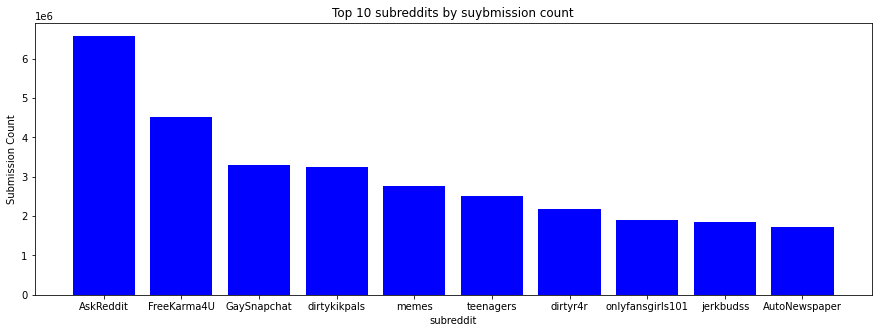

In [0]:
## Import data visualization packages
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
plt.bar("subreddit", "count", data = top_n_subreddits, color = "blue")
plt.xlabel("subreddit")
plt.ylabel("Submission Count")
plt.title(f"Top {top_n} subreddits by suybmission count")

## Save the plot in the plot dir so that it can be checked in into the repo
plot_fpath = os.path.join(PLOT_DIR, f'top_{top_n}_subreddits.png')

plt.savefig(plot_fpath)
plt.show()

In [0]:
## save the csv file in the csv dir
fpath = os.path.join(CSV_DIR, "top_n_subreddits.csv")
top_n_subreddits.to_csv(fpath)

## Saving data to DBFS
Sometimes we may want to save intermediate data, especially if it is big and took a significant time to generate, in DBFS. The following code shows an example of this. We save submissions on the `memes` subreddit into dbfs so that we can read from it at a later stage.

In [0]:

submissions_filtered = submissions.filter(submissions.subreddit == "memes")

In [0]:
submissions_filtered.show()

+------------------+------------------+--------+---------------+--------------+----------------------+--------------------+---------+----------+------------+-----------+----------------+---------------------+----------------+-------------+-----------+---------------+------+----------+---------+------+------+----------+--------+------+---------+----------------+----------------------+-------+--------+--------------------+---------------+------+--------------------+--------------------+-------------+------------+--------------+-------------+-------+-----------------------+--------------------+------+---------+--------------------+--------+-----------+---------------------+------------+------------+-----+------------------+--------------------+---------+-------+--------+---------+------------+--------------+--------------------+--------------------+----------------------+--------------------+----------------+---------------+--------------------+--------------------+----------------+
|adse

In [0]:
# this code saves the data as a csv just for illustration, use parquet for faster analytics operations.
submissions_filtered.select("author_id", "title", "selftext").write.format('com.databricks.spark.csv').save("/FileStore/memes")

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
<command-1947001387758009> in <cell line: 2>()
      1 # this code saves the data as a csv just for illustration, use parquet for faster analytics operations.
----> 2 submissions_filtered.select("author_id", "title", "selftext").write.format('com.databricks.spark.csv').save("/FileStore/memes")

/databricks/spark/python/pyspark/instrumentation_utils.py in wrapper(*args, **kwargs)
     46             start = time.perf_counter()
     47             try:
---> 48                 res = func(*args, **kwargs)
     49                 logger.log_success(
     50                     module_name, class_name, function_name, time.perf_counter() - start, signature

/databricks/spark/python/pyspark/sql/readwriter.py in save(self, path, format, mode, partitionBy, **options)
    966             self._jwrite.save()
    967         else:
--> 968           

In [0]:
memes = spark.read.csv("/FileStore/memes")
memes.show()

+----+--------------------+---------+
| _c0|                 _c1|      _c2|
+----+--------------------+---------+
|null|   [deleted by user]|[removed]|
|null|Jerry the skeleto...|     null|
|null|What a relief it is.|     null|
|null|   [deleted by user]|[removed]|
|null|Its an American r...|     null|
|null|   [deleted by user]|[removed]|
|null|Y'all better foll...|     null|
|null|   [deleted by user]|[removed]|
|null|For me only 1 hou...|     null|
|null|    Happy Spooktober|     null|
|null|   [deleted by user]|[removed]|
|null|Was it worth it? ...|     null|
|null|Looks like this g...|     null|
|null| It do be like that…|     null|
|null|           Meta Mark|     null|
|null|dagummit, maybe i...|     null|
|null|   [deleted by user]|[removed]|
|null|   [deleted by user]|[removed]|
|null|   [deleted by user]|[removed]|
|null|   [deleted by user]|[removed]|
+----+--------------------+---------+
only showing top 20 rows

